In [1]:
using Pkg
Pkg.activate(".")
Pkg.add([
    "Graphs", "GraphPlot", "Combinatorics", "GraphIO", 
    "Plots", "Statistics", "StatsBase", "JSON", 
    "Compose", "Colors", "Cairo", "Fontconfig", "Crayons"
])

# Graph Analysis & Algorithms
using Graphs, GraphIO, Combinatorics

# Data Processing & Stats
using JSON, Statistics, StatsBase

# Visualization & Rendering
using Plots, GraphPlot, Compose, Colors, Cairo, Fontconfig, Crayons

# Multithreading for performance
using .Threads

  Activating project at `~/git/LearningAugmentedDensestSubgraph`
   Resolving package versions...
     Project No packages added to or removed from `~/git/LearningAugmentedDensestSubgraph/Project.toml`
    Manifest No packages added to or removed from `~/git/LearningAugmentedDensestSubgraph/Manifest.toml`


In [2]:
# graphs = pairs of (graph name, graph object)
graphs = loadgraphs("datasets/graphs.lg")
println("Loaded $(length(graphs)) graphs for analysis and visualization.")


Loaded 300 graphs for analysis and visualization.


## Distribution of number of nodes in graphs:

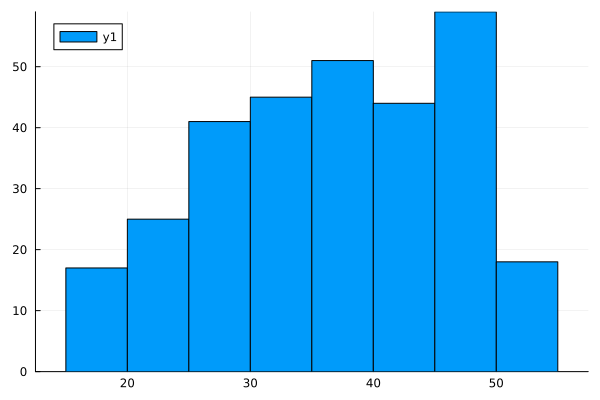

In [3]:
histogram([nv(g) for (key, g) in graphs])

# Pre-processing Functions

In [4]:
"""
    Density function.
"""
function density(g)
    ne(g) / nv(g)
end

"""
    Get a lower bound on the DamkS by peeling min-degree vertices until `k` vertices are left.
    Call this H. Then pell min-degree vertices from H until the graph is empty.
    Maintain and return the best density found during the process.
    Since each snapshot of H is a feasible solution to the DamkS, this is a lower bound on the optimal density.
"""

function greedy_damks_estimate(g, k)
    h = deepcopy(g)

    # Remove vertices with minimum degree until the graph has `k` vertices left
    for c in 1:(nv(g) - k)
        min_d, min_v = findmin(v -> length(neighbors(h, v)), vertices(h))
        rem_vertex!(h, min_v)
    end

    # Remove vertices to check for better density
    dprime = density(h)
    for c in 1:min(k-1, nv(h))
        min_d, min_v = findmin(v -> length(neighbors(h, v)), vertices(h))
        rem_vertex!(h, min_v)
        if density(h) > dprime
            dprime = density(h)
        end
    end

    return dprime
end

"""
    Prune vertices that have degree lower than `d` until no more vertices can be removed.
    If `d` is a lower bound on the optimal density, then the pruned graph must contain the optimal solution.
    Return the pruned graph and the mapping from the pruned graph's vertices to the original
"""
function prune_graph(g, d)
    can_rem = true
    h = deepcopy(g)
    # Since Graph Jl relabels vertices after removing, we need to keep track of the original vertex indices
    idx_map = [i for i in 1:nv(g)] 
    while can_rem
        to_be_rem = Vector{Int64}()
        for v in 1:nv(h)
            if length(neighbors(h, v)) < d
                push!(to_be_rem, v)
            end 
        end
        can_rem = length(to_be_rem) > 0
        survived_idx = rem_vertices!(h, to_be_rem)
        new_idx_map = [idx_map[survived_idx[i]] for i in 1:length(survived_idx)]
        idx_map = new_idx_map
    end
    survived_idx = [idx_map[i] for i in 1:nv(h)]
    h, survived_idx
end

prune_graph

# Pruning
Use pre-processing to remove some nodes from the graphs that are guaranteed to not be in the optimal solution.

We restrict our experiments to graph (after prunning) up to a certain size since exact algorithms are computationally expensive.

In [5]:
K = 15 # parameter k
MAX_SIZE = 30 # filter graph whose filted size is larger than this 

pruned = Dict() 

for (gn ,g) in graphs
    dprime = greedy_damks_estimate(g, K)
    h, survived_idx = prune_graph(g, dprime)

    if nv(h) > MAX_SIZE
        continue
    end

    pruned[gn] = Dict()
    pruned[gn][:original] = g
    pruned[gn][:pruned] = h
    pruned[gn][:pruned_vmap] = survived_idx
end

# Size distribution after pruning

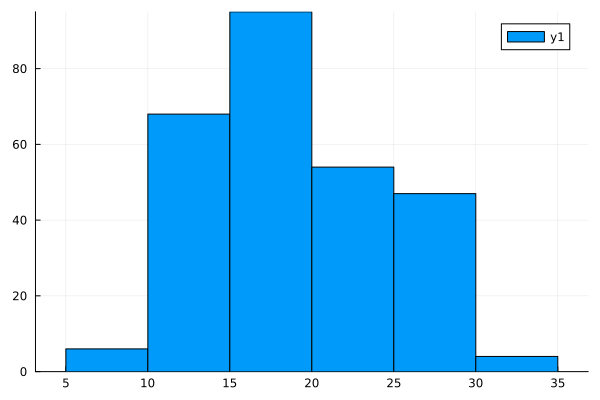

In [6]:
histogram([nv(ginfo[:pruned]) for (gn, ginfo) in pruned])

# Densest At-most-k Subgraph

### 1. True DamkS

In [10]:
"""
    Exact algorithm to find the densest k subgraph
"""
function exact_dks(g, k)
    dks_vlist = nothing
    dks_density = 0
    adj = [neighbors(g, v) for v in 1:nv(g)]
    
    for vec in combinations(1:nv(g), k)
        e_count = 0
        vset = Set(vec)
        for v in vec
            for neighbor in adj[v]
                if neighbor in vset
                    e_count += 1
                end
            end
        end

        e_count = e_count / 2 
        if e_count / k > dks_density
            dks_density = e_count / k
            dks_vlist = vec
        end

    end
    dks_vlist, dks_density
end

"""
    Exact algorithm to find the densest at-most-k subgraph
"""
function exact_damks(g, k)
    damks_vlist = nothing
    damks_density = 0
    for ks in 2:k
        dks_vlist, dks_density = exact_dks(g, ks)
        if dks_density > damks_density
            damks_density = dks_density
            damks_vlist = dks_vlist
        end
    end
    damks_vlist, damks_density
end

"""
    Create a dictionary of the true densities of DamkS for all graphs.
"""
function true_densities(graphs, k)
    # Exact algorithm to find the density of DamkS
    Dict(
        gn => exact_damks(ginfo[:pruned], k) for (gn, ginfo) in graphs
    )
end

"""
    Plots the original graph with the discovered dense subgraph highlighted.
"""
function plot_dense_subgraph(g, vlist)
    # 1. Convert list to a Set for O(1) lookup speed
    highlight_set = Set(vlist)
    
    # 2. Node Colors: Subgraph = Orange, Rest = Black
    node_colors = [v in highlight_set ? colorant"orange" : colorant"black" for v in 1:nv(g)]
    
    # 3. Edge Styles
    edge_colors = Colorant[]
    edge_widths = Float64[]
    
    for e in edges(g)
        # Check if both ends of the edge are in our highlight set
        if src(e) in highlight_set && dst(e) in highlight_set
            push!(edge_colors, colorant"red")
            push!(edge_widths, 2.5) 
        else
            # Background edges: Solid Black
            push!(edge_colors, colorant"black") 
            push!(edge_widths, 0.3)
        end
    end
    
    # 4. Render
    return gplot(g, 
          nodefillc=node_colors, 
          edgestrokec=edge_colors, 
          edgelinewidth=edge_widths,
          NODESIZE=0.012,
          layout=spring_layout)
end

plot_dense_subgraph

## Test on 3 graphs

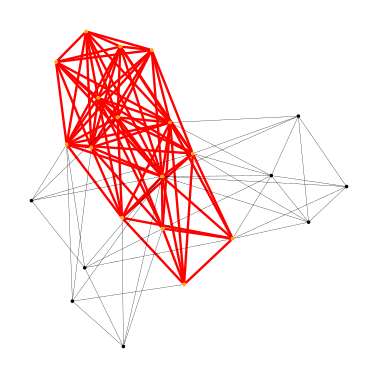

Graph: 3
Density = 5.0
Vertices in dense subgraph: 15
Graph: 1
Density = 5.466666666666667
Vertices in dense subgraph: 15
Graph: 5
Density = 5.533333333333333
Vertices in dense subgraph: 15


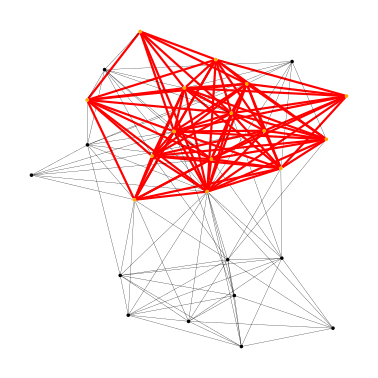

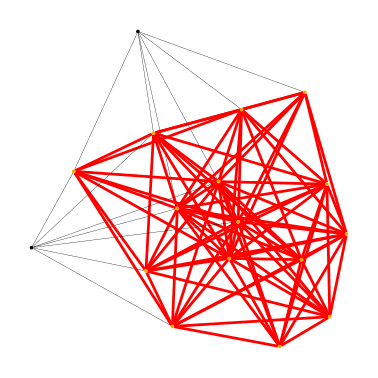

In [ ]:

test_count = 3
for gn in keys(pruned)
    println("Graph: $gn")
    pruned_g = pruned[gn][:pruned]
    original_g = pruned[gn][:original]
    damks_vlist, damks_density = exact_damks(pruned_g, K)
    p = plot_dense_subgraph(pruned_g, damks_vlist)
    display(p) 
    println("Density = $damks_density")
    println("Vertices in dense subgraph: $(length(damks_vlist))")

    test_count -= 1
    if test_count == 0
        break
    end
end


## Check number of threads

Set number of threads in VS code settings.
Search for "julia.numThreads"

In [7]:
if (nthreads() > 1)
    println("Running with $(nthreads()) threads for parallel computations.")
else
    println("Running in single-threaded mode. Consider enabling multithreading for better performance.")
end

Running with 8 threads for parallel computations.


## Compute ground truth DamkS for all graphs using multi-threading

In [8]:
# Define some styles for the terminal
info_style = Crayon(foreground = :cyan, bold = true)
success_style = Crayon(foreground = :green)
stat_style = Crayon(foreground = :magenta)
reset = Crayon(reset = true)

\e

In [11]:

function compute_export_mt(pruned::Dict, K)
    names = collect(keys(pruned))
    out = Vector{Tuple{typeof(names[1]), Dict{String, Any}}}(undef, length(names))

    Threads.@threads for i in eachindex(names)
        gn = names[i]
        ginfo = pruned[gn]

        orig_g   = ginfo[:original]
        pruned_g = ginfo[:pruned]

        # exact densest subgraph on pruned graph
        raw_vlist, dens = exact_damks(pruned_g, K)

        # map pruned vertex ids back to original ids
        mapped_vlist = [ginfo[:pruned_vmap][v] for v in raw_vlist]

        out[i] = (gn, Dict(
            "size"          => nv(orig_g),
            "edges"         => [(src(e), dst(e)) for e in edges(orig_g)],
            "damks_vlist"   => mapped_vlist,
            "damks_density" => dens,
        ))

        print(success_style, "Finished computing DamkS for graph ", reset)
        print(info_style, gn, reset)
        println()
    end

    return Dict(out)
end

export_dict = compute_export_mt(pruned, K)

open("outputs/all.json", "w") do f
    JSON.print(f, export_dict)
end

println(success_style, "Exported all results to outputs/all.json", reset)

Finished computing DamkS for graph 402Finished computing DamkS for graph 110

Finished computing DamkS for graph 418
Finished computing DamkS for graph 514
Finished computing DamkS for graph 236
Finished computing DamkS for graph 33
Finished computing DamkS for graph 333
Finished computing DamkS for graph 552
Finished computing DamkS for graph 292
Finished computing DamkS for graph 545
Finished computing DamkS for graph 105
Finished computing DamkS for graph 3
Finished computing DamkS for graph 81
Finished computing DamkS for graph 549
Finished computing DamkS for graph 445
Finished computing DamkS for graph 431
Finished computing DamkS for graph 104
Finished computing DamkS for graph 238
Finished computing DamkS for graph 209
Finished computing DamkS for graph 185
Finished computing DamkS for graph 70
Finished computing DamkS for graph 349
Finished computing DamkS for graph 191
Finished computing DamkS for graph 304
Finished computing DamkS for graph 338
Finished computing DamkS for g

In [12]:

# 1. Load the results
results = JSON.parsefile("outputs/all.json")
graph_keys = sort(collect(keys(results)))
total = length(graph_keys)

println(info_style, "\n🚀 Starting Plotting Engine", reset)
println("Found ", stat_style, "$total", reset, " graphs to process.\n")

# 2. Iterate through the results with style
for (i, gn) in enumerate(graph_keys)    
    # Extract data
    res = results[gn]
    damks_vlist = res["damks_vlist"]
    damks_density = res["damks_density"]
    n_nodes = res["size"]
    edge_data = res["edges"] 

    # Reconstruct the graph
    g = SimpleGraph(n_nodes)
    for e in edge_data
        add_edge!(g, e[1], e[2])
    end

    # Generate and save plot
    p = plot_dense_subgraph(g, damks_vlist)
    output_path = "outputs/plot_$(gn).png"
    draw(PNG(output_path, 16cm, 16cm), p)

    # Nice progress line: [1/10] Processing Graph: 1 | Density: 0.850
    print(info_style, "[$(lpad(i, length(string(total))))/$total] ", reset)
    print("Graph: ", stat_style, rpad(gn, 5), reset)
    print(" | Density: ", success_style, rpad(round(damks_density, digits=3), 5), reset)
    println(" | 🖼️  Saved to ", crayon"italics"("outputs/"))
end

println(info_style, "\n✅ All plots generated successfully!", reset)


🚀 Starting Plotting Engine
Found 274 graphs to process.

[  1/274] Graph: 1     | Density: 5.467 | 🖼️  Saved to outputs/
[  2/274] Graph: 10    | Density: 4.467 | 🖼️  Saved to outputs/
[  3/274] Graph: 104   | Density: 4.067 | 🖼️  Saved to outputs/
[  4/274] Graph: 105   | Density: 5.333 | 🖼️  Saved to outputs/
[  5/274] Graph: 109   | Density: 2.733 | 🖼️  Saved to outputs/
[  6/274] Graph: 110   | Density: 4.143 | 🖼️  Saved to outputs/
[  7/274] Graph: 111   | Density: 3.8   | 🖼️  Saved to outputs/
[  8/274] Graph: 113   | Density: 5.867 | 🖼️  Saved to outputs/
[  9/274] Graph: 114   | Density: 5.067 | 🖼️  Saved to outputs/
[ 10/274] Graph: 116   | Density: 5.2   | 🖼️  Saved to outputs/
[ 11/274] Graph: 118   | Density: 3.643 | 🖼️  Saved to outputs/
[ 12/274] Graph: 122   | Density: 2.125 | 🖼️  Saved to outputs/
[ 13/274] Graph: 125   | Density: 3.933 | 🖼️  Saved to outputs/
[ 14/274] Graph: 126   | Density: 6.933 | 🖼️  Saved to outputs/
[ 15/274] Graph: 127   | Density: 3.067 | 🖼️  